# Mounting Drive For Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Jumps to the desired directory
%cd 'drive/My Drive/Analytical Data'

/content/drive/My Drive/Analytical Data


# Prepering Data 

In [ ]:
import numpy as np
from numpy import genfromtxt

In [ ]:
p =[]
p.append(genfromtxt('T_q100_v200_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q100_v300_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q100_v400_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q100_v400_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q150_v400_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q200_v500_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q200_v800_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q200_v1000_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q200_v1200_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q200_v1500_T25_D100.csv', delimiter=','))
p.append(genfromtxt('T_q300_v1000_T25_D100.csv', delimiter=','))

In [ ]:
for i in range(len(p)):
   p[i] = np.delete(p[i], 0, 1) 
   p[i] = np.delete(p[i], 2, 1) 
   p[i] = np.delete(p[i], 2, 1) 

### Normalizing

In [ ]:
# Normalizing
# Normalizing the temperatures:
for l in range(len(p)):
  temps = p[l]
  temps_mean = np.zeros(100)
  temps_std = np.zeros(100)
  for j in range(100):
    i = j + 2
    temps_mean[j] = temps[:,i].mean()
    temps_std[j] = temps[:,i].std()
    temps[:,i] = (temps[:,i] - temps_mean[j]) / temps_std[j]

In [ ]:
n_steps_past = 50
n_steps_ahead = 50

In [ ]:
data1 = np.zeros([len(p), 41, 41, n_steps_past])
data2 = np.zeros([len(p), 41, 41, n_steps_ahead])
for t in range(len(p)):
  csv = p[t]
  for i in range(len(csv)):
      for j in range(n_steps_past):
          data1[t][int(csv[i][0] - 1)][int(csv[i][1] - 1)][j] = csv[i][j + 2]
      for j in range(n_steps_ahead):
          k = j + n_steps_ahead
          data2[t][int(csv[i][0] - 1)][int(csv[i][1] - 1)][j] = csv[i][k + 2]

In [ ]:
data1 = data1.reshape((11,n_steps_past, 41, 41, 1))
data2 = data2.reshape((11,n_steps_ahead, 41, 41, 1))

In [ ]:
print(data1.shape)
print(data2.shape)

(11, 50, 41, 41, 1)
(11, 50, 41, 41, 1)


Now we have 11 Diferent Planes, each 41*41 

# Model

In [ ]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

In [ ]:
im_size = 41

In [ ]:
seq = Sequential()

seq.add(ConvLSTM2D(filters=im_size, kernel_size=(3, 3),
                   input_shape=(None, im_size, im_size, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=im_size, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=im_size, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=im_size, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

In [ ]:
seq.fit(data1[:9], data2[:9], batch_size=10, epochs=5, validation_split=0.05)

Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 1.1206 - val_loss: 0.6949
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 1.1140 - val_loss: 0.6942
Epoch 3/5
1/1 [==============================] - 3s 3s/step - loss: 1.1075 - val_loss: 0.6935
Epoch 4/5
1/1 [==============================] - 3s 3s/step - loss: 1.1009 - val_loss: 0.6928
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 1.0943 - val_loss: 0.6921


# Test on new Plane

In [ ]:
which = 10
track = data1[which][:7, ::, ::, ::]

In [ ]:
track.shape, track[np.newaxis, ::, ::, ::, ::].shape

((7, 41, 41, 1), (1, 7, 41, 41, 1))

In [ ]:
for j in range(16):
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::]) # (1, 7, 40, 40, 1)
    new = new_pos[::, -1, ::, ::, ::] # (1, 40, 40, 1)
    track = np.concatenate((track, new), axis=0) # adds +1 to the first dimension in each loop cycle

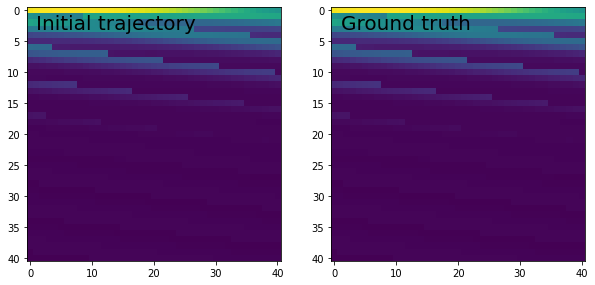

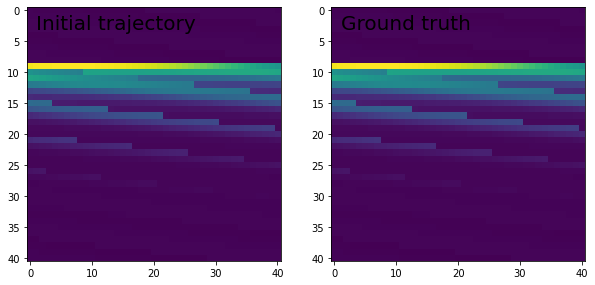

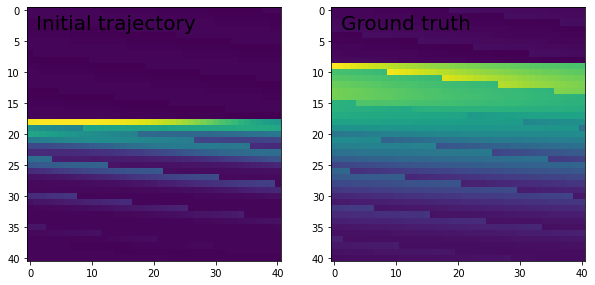

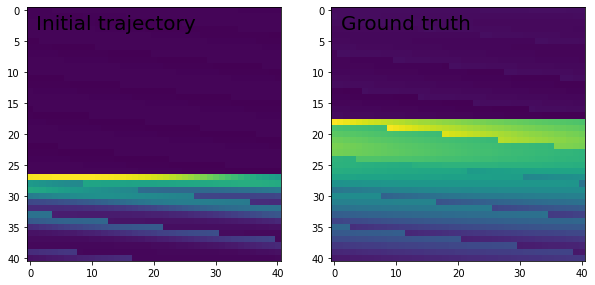

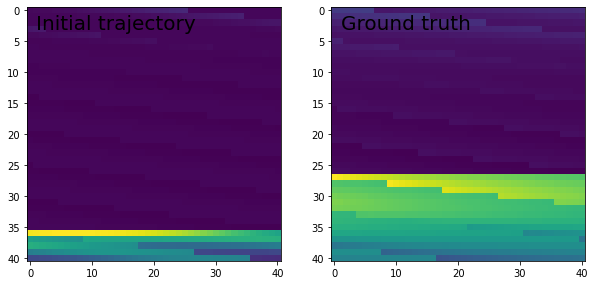

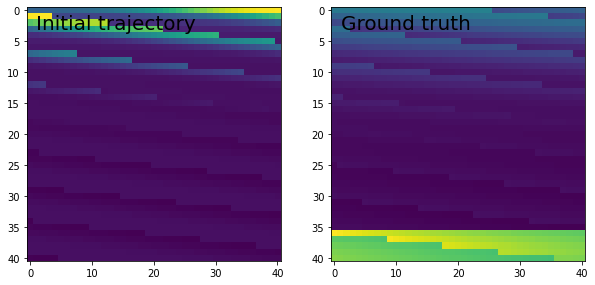

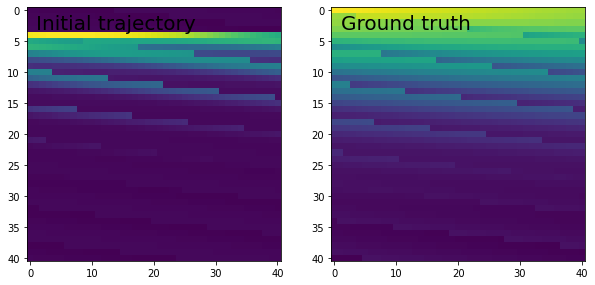

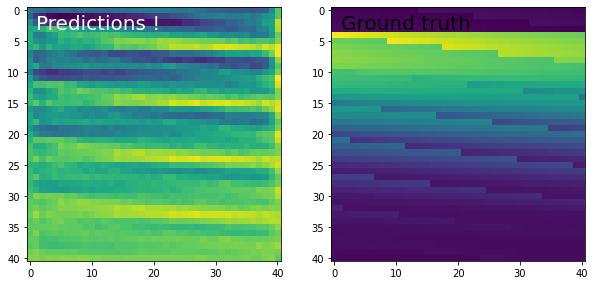

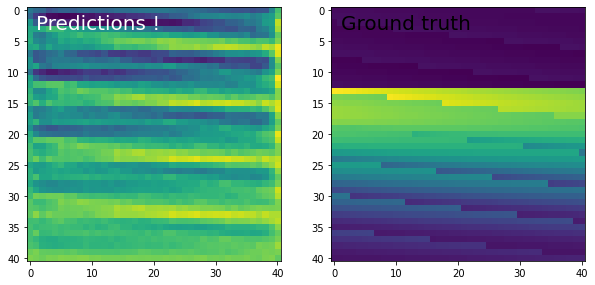

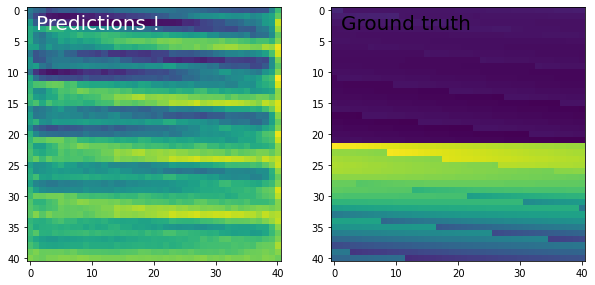

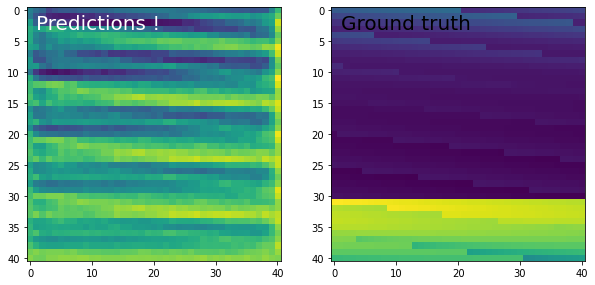

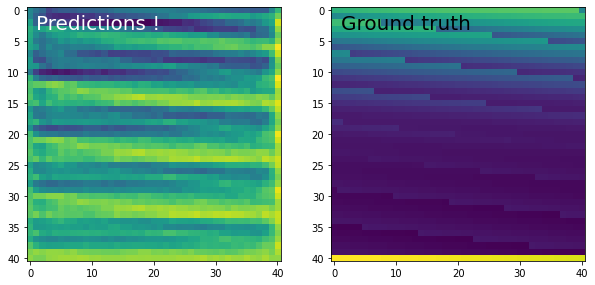

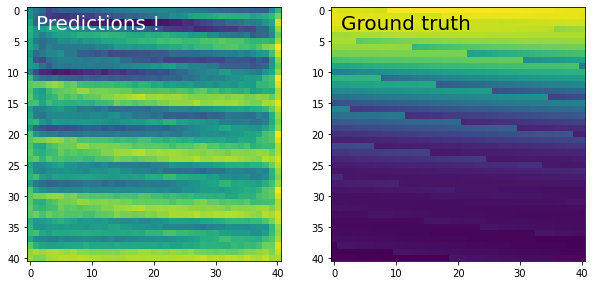

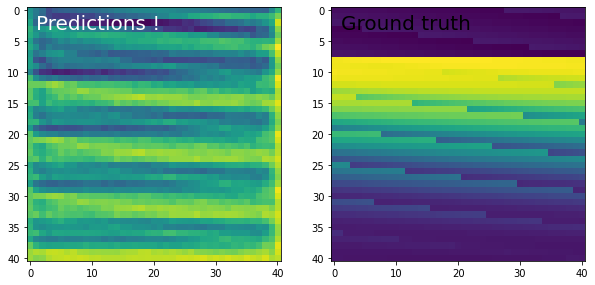

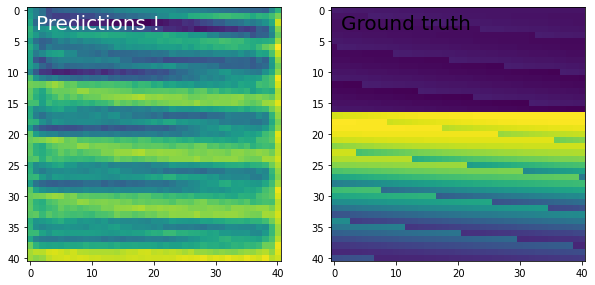

In [ ]:
track2 = data1[which][::, ::, ::, ::]

for i in range(15):
    fig = plt.figure(figsize=(10, 5))

    ax = fig.add_subplot(121)

    if i >= 7:
        ax.text(1, 3, 'Predictions !', fontsize=20, color='w')
    else:
        ax.text(1, 3, 'Initial trajectory', fontsize=20)

    toplot = track[i, ::, ::, 0]

    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)

    toplot = track2[i, ::, ::, 0]
    if i >= 2:
        toplot = data2[which][i - 1, ::, ::, 0]

    plt.imshow(toplot)